<a href="https://colab.research.google.com/github/JotaPMendes/facial_recognition_ann/blob/main/projeto1_reconhecimentofacial_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Reconhecimento Facial com PyTorch e MLP

Este notebook implementa um sistema completo de reconhecimento facial utilizando apenas redes neurais densas (MLP) sem o uso de embeddings pré-treinados, conforme especificado nos requisitos do projeto.

## 1- Instalação de Dependências

Instalando as bibliotecas necessárias para o projeto.

In [4]:
pip install torchvision opencv-python scikit-learn tqdm pillow

## 2- Importação de Bibliotecas

In [5]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from PIL import Image
import random
from google.colab import drive
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import io

In [6]:
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


## 3- Detecção e Alinhamento Facial

Implementação da classe `FaceDetector` para detectar, recortar e alinhar faces nas imagens.

In [7]:
class FaceDetector:
  def __init__(self):
    haar_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    self.face_cascade = cv2.CascadeClassifier(haar_path)

    eye_path = cv2.data.haarcascades + 'haarcascade_eye.xml'
    self.eye_cascade = cv2.CascadeClassifier(eye_path)

  def detect_face(self, image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    faces = self.face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    valid_faces = []
    for (x, y, w, h) in faces:
      aspect_ratio = w / h
      if 0.7 < aspect_ratio < 1.3 and w > 50 and h > 50:
        valid_faces.append((x, y, w, h))

    if not valid_faces:
      faces = self.face_cascade.detectMultiScale(
          gray,
          scaleFactor=1.01,
          minNeighbors=3,
          minSize=(20, 20),
          flags=cv2.CASCADE_SCALE_IMAGE
      )
      for (x, y, w, h) in faces:
        aspect_ratio = w / h
        if 0.7 < aspect_ratio < 1.3 and w > 50 and h > 50:
          valid_faces.append((x, y, w, h))

    return valid_faces

  def crop_face(self, image, face_box):
    x, y, w, h = face_box
    cropped_face = image[y:y+h, x:x+w]
    return cropped_face

  def preprocess_image(self, image_path, target_size=(128, 128)):
    try:
      image = cv2.imread(image_path)
      if image is None:
        print(f"Aviso: não foi possivel carregar a imagem {image_path}")
        return None

      alpha = 1.3
      beta = 10
      image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
      faces = self.detect_face(image)
      if not faces:
        print(f"Aviso: nenhuma face foi detectada em {image_path}")
        return None

      largest_face = max(faces, key=lambda box: box[2] * box[3])
      face_img = self.crop_face(image, largest_face)
      face_img = cv2.resize(face_img, target_size)
      return face_img

    except Exception as e:
      print(f"Erro ao processar a imagem {image_path}: {e}")
      return None

  def process_directory(self, input_dir, output_dir, target_size=(128, 128)):
    os.makedirs(output_dir, exist_ok=True)
    image_extensions = ['.jpg', '.jpeg', '.png']
    image_files = []

    for root, _, files in os.walk(input_dir):
      for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
          image_files.append(os.path.join(root, file))

    print(f"Encontradas {len(image_files)} imagens para processar.")
    processed_count = 0

    for image_path in image_files:
      rel_path = os.path.relpath(image_path, input_dir)
      output_path = os.path.join(output_dir, os.path.basename(image_path))
      os.makedirs(os.path.dirname(output_path), exist_ok=True)
      face_img = self.preprocess_image(image_path, target_size)
      if face_img is not None:
        cv2.imwrite(output_path, face_img)
        processed_count += 1

    print(f"Processamento concluído. {processed_count} imagens processadas.")


## 4- Processamento de Dados

Implementação das classes `FaceDataset` e `DataProcessor` para processar os dados de face para treinamento e teste.

In [8]:
class FaceDataset(Dataset):
    def __init__(self, images, labels, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
class DataProcessor:
    def __init__(self, image_size = (128, 128)):
        self.image_size = image_size

    def load_data(self, data_dir):
        images = []
        labels = []
        label_mapping = {}
        person_names = {}

        image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if not image_files:
            print(f"Aviso: Nenhuma imagem encontrada em {data_dir}.")
            return images, labels, label_mapping

        print(f"Encontradas {len(image_files)} imagens em {data_dir}.")

        for image_file in sorted(image_files):
            try:
                name_parts = image_file.rsplit('_', 1)
                if len(name_parts) == 2 and name_parts[1].split('.')[0].isdigit():
                    person_name = name_parts[0]
                else:
                    print(f"Aviso: Nome inválido no arquivo {image_file}. Ignorando.")
                    continue

                if person_name not in person_names:
                    person_idx = len(person_names)
                    person_names[person_name] = person_idx
                    label_mapping[person_idx] = person_name

                image_path = os.path.join(data_dir, image_file)
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Aviso: Não foi possível ler a imagem {image_path}.")
                    continue

                image = cv2.resize(image, self.image_size)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images.append(image)
                labels.append(person_names[person_name])

            except Exception as e:
                print(f"Erro ao processar {image_file}: {str(e)}")

        print(f"Carregadas {len(images)} imagens de {len(person_names)} pessoas.")

        images = np.array(images)
        labels = np.array(labels)

        return images, labels, label_mapping

    def preprocess_data(self, images, labels, test_size = 0.2, random_state = 42):
        num_classes = len(np.unique(labels))
        labels = labels.astype(np.int64)
        min_samples_per_class = np.min(np.bincount(labels))
        if test_size * len(labels) < num_classes:
            test_size = max(num_classes / len(labels), 0.1)
            print(f"Aviso: O valor de test_size foi ajustado para {test_size}.")

        X_train, X_test, y_train, y_test = train_test_split(
            images, labels, test_size=test_size, random_state=random_state, stratify=labels
        )

        X_train = torch.tensor(X_train.transpose(0, 3, 1, 2) / 255.0, dtype = torch.float32)
        X_test = torch.tensor(X_test.transpose(0, 3, 1, 2) / 255.0, dtype = torch.float32)
        y_train = torch.tensor(y_train, dtype = torch.long)
        y_test = torch.tensor(y_test, dtype = torch.long)

        train_dataset = FaceDataset(X_train, y_train)
        test_dataset = FaceDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
        test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

        return train_loader, test_loader, num_classes

    def apply_data_augmentation(self, images, labels, augmentation_factor = 2):
        augmented_images = []
        augmented_labels = []

        augmented_images.extend(images)
        augmented_labels.extend(labels)

        for i in range(len(images)):
            image = images[i]
            label = labels[i]

            for _ in range(augmentation_factor):
                augmented_image = image.copy()
                if random.random() > 0.5:
                    augmented_image = cv2.flip(augmented_image, 1)
                angle = random.uniform(-15, 15)
                rows, cols, _ = augmented_image.shape
                M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
                augmented_image = cv2.warpAffine(augmented_image, M, (cols, rows))

                alpha = random.uniform(0.8, 1.2)
                beta = random.randint(-30, 30)
                augmented_image = cv2.convertScaleAbs(augmented_image, alpha=alpha, beta=beta)

                augmented_images.append(augmented_image)
                augmented_labels.append(label)

        augmented_images = np.array(augmented_images)
        augmented_labels = np.array(augmented_labels)

        print(f"Imagens geradas após aumento de dados: {len(augmented_images)}")

        return augmented_images, augmented_labels

## 5- Modelo de Rede Neural

Implementação do modelo de MLP para reconhecimento facial.

In [10]:
class FaceRecognitionMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate = 0.5):
        super(FaceRecognitionMLP, self).__init__()
        layers = []

        layers.append(nn.Linear(input_size, hidden_size[0]))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_size[0]))
        layers.append(nn.Dropout(dropout_rate))

        for i in range(len(hidden_size) - 1):
            layers.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size[i + 1]))
            layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_size[-1], num_classes))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
      x = x.reshape(x.size(0), -1)
      x = self.layers(x)
      return x

    def create_mlp_model(input_shape, num_classes):
        input_size = np.prod(input_shape)
        hidden_size = [2048, 1024, 512, 256]
        model = FaceRecognitionMLP(input_size, hidden_size, num_classes)
        return model

## 6- Treinamento e Avaliação do Modelo
Funções para treinar e avaliar o modelo de reconhecimento facial.

In [11]:
def train_model(model, train_loader, test_loader, num_epochs=50, learning_rate=0.001,
                device='cuda' if torch.cuda.is_available() else 'cpu',
                model_save_path='models/face_recognition_mlp.pth'):

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            train_pbar.set_postfix({'loss': loss.item(), 'acc': train_correct / train_total})

        train_loss = train_loss / train_total
        train_acc = train_correct / train_total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

            for inputs, labels in val_pbar:

                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_pbar.set_postfix({'loss': loss.item(), 'acc': val_correct / val_total})

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
            torch.save(model.state_dict(), model_save_path)
            print(f'  Saved new best model with validation accuracy: {val_acc:.4f}')

    model.load_state_dict(torch.load(model_save_path))

    return model, history

def evaluate_model(model, test_loader, label_mapping, device='cuda' if torch.cuda.is_available() else 'cpu'):

    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds)

    class_names = [label_mapping[i] for i in range(len(label_mapping))]
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    accuracy = (all_preds == all_labels).mean()

    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report
    }

def plot_training_history(history, save_path='/content/MyDrive/MyDrive/faculdade_cdia_2023_2026/5-semestre/aprendizagem_maquina_5-semestre/projeto1_reconhecimentofacial_mlp/models/training_history.png'):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss over Epochs')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy over Epochs')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

## 7- Sistema de Inferência

Implementação da classe `FaceRecognitionSystem` para realizar reconhecimento facial usando o modelo treinado.

In [12]:
class FaceRecognitionSystem:

    def __init__(self, model_path, label_mapping, image_size=(128, 128),
                 device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.image_size = image_size
        self.label_mapping = label_mapping
        self.device = device

        self.face_detector = FaceDetector()

        input_shape = (3, image_size[0], image_size[1])
        num_classes = len(label_mapping)
        self.model = FaceRecognitionMLP.create_mlp_model(input_shape, num_classes)
        self.model.load_state_dict(torch.load(model_path, map_location=device))
        self.model.to(device)
        self.model.eval()

    def recognize_face(self, image_path):

        face_img = self.face_detector.preprocess_image(image_path, self.image_size)

        if face_img is None:
            return None, 0.0

        face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)

        face_tensor = torch.tensor(face_img_rgb.transpose(2, 0, 1) / 255.0,
                                  dtype=torch.float32).unsqueeze(0).to(self.device)

        with torch.no_grad():
            outputs = self.model(face_tensor)
            probabilities = F.softmax(outputs, dim=1)
            conf, pred_idx = torch.max(probabilities, 1)

            predicted_idx = pred_idx.item()
            confidence = conf.item()

            predicted_person = self.label_mapping[predicted_idx]

        return predicted_person, confidence

    def recognize_face_from_image(self, image):

        faces = self.face_detector.detect_face(image)

        if not faces:
            return None, 0.0, None

        largest_face = max(faces, key=lambda box: box[2] * box[3])

        face_img = self.face_detector.crop_face(image, largest_face)
        face_img = cv2.resize(face_img, self.image_size)

        face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)

        face_tensor = torch.tensor(face_img_rgb.transpose(2, 0, 1) / 255.0,
                                  dtype=torch.float32).unsqueeze(0).to(self.device)

        with torch.no_grad():
            outputs = self.model(face_tensor)
            probabilities = F.softmax(outputs, dim=1)
            conf, pred_idx = torch.max(probabilities, 1)

            predicted_idx = pred_idx.item()
            confidence = conf.item()

            predicted_person = self.label_mapping[predicted_idx]

        return predicted_person, confidence, largest_face

    def visualize_recognition(self, image_path, output_path=None):

        image = cv2.imread(image_path)

        if image is None:
            print(f"Warning: Could not read image {image_path}")
            return None

        person, confidence, face_box = self.recognize_face_from_image(image)

        if person is None:
            print(f"Warning: No face detected in {image_path}")
            return image

        x, y, w, h = face_box
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        label = f"{person}: {confidence:.2f}"
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)

        if output_path:
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            cv2.imwrite(output_path, image)

        return image

## 8- Sistema por Webcam

Criando uma classe para fazer reconhecimento por Webcam.

In [13]:
class WebcamFaceRecognition:
    def __init__(self, face_recognition_system):
        self.face_recognition_system = face_recognition_system

    def _capture_image(self):
        js = Javascript('''
            async function captureImage() {
                const div = document.createElement('div');
                const capture = document.createElement('button');
                capture.textContent = 'Capturar imagem';
                div.appendChild(capture);

                const video = document.createElement('video');
                video.style.display = 'block';
                div.appendChild(video);

                document.body.appendChild(div);

                const stream = await navigator.mediaDevices.getUserMedia({ video: true });
                video.srcObject = stream;
                await video.play();

                await new Promise((resolve) => capture.onclick = resolve);

                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);

                stream.getTracks().forEach(track => track.stop());
                div.remove();

                return canvas.toDataURL('image/jpeg');
            }
            captureImage();
        ''')
        display(js)
        data = eval_js("captureImage()")
        binary = b64decode(data.split(',')[1])
        image = Image.open(io.BytesIO(binary))
        return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    def run_once(self):
        image = self._capture_image()
        person, confidence, face_box = self.face_recognition_system.recognize_face_from_image(image)
        if person is not None:
            x, y, w, h = face_box
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            label = f"{person}: {confidence:.2f}"
            cv2.putText(image, label, (x, max(y - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)
        _, buffer = cv2.imencode('.jpg', image)
        display(Image.open(io.BytesIO(buffer)))

## 9- Execução Principal

Fluxo completo de processamento, treinamento e inferência.

### 9.1 Detecção e Processamento de Faces

In [14]:
IMAGE_SIZE = (128, 128)
DATA_DIR = '/content/MyDrive/MyDrive/faculdade_cdia_2023_2026/5-semestre/aprendizagem_maquina_5-semestre/projeto1_reconhecimentofacial_mlp/raw_images'
PROCESSED_DIR = '/content/MyDrive/MyDrive/faculdade_cdia_2023_2026/5-semestre/aprendizagem_maquina_5-semestre/projeto1_reconhecimentofacial_mlp/processed_images'
MODEL_SAVE_PATH = '/content/MyDrive/MyDrive/faculdade_cdia_2023_2026/5-semestre/aprendizagem_maquina_5-semestre/projeto1_reconhecimentofacial_mlp/models/models.pt'
HISTORY_SAVE_PATH = '/content/MyDrive/MyDrive/faculdade_cdia_2023_2026/5-semestre/aprendizagem_maquina_5-semestre/projeto1_reconhecimentofacial_mlp/models/models_history.pt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [15]:
face_detector = FaceDetector()
face_detector.process_directory(DATA_DIR, PROCESSED_DIR, IMAGE_SIZE)

if not os.path.exists(PROCESSED_DIR):
    print(f"Erro: Diretório {PROCESSED_DIR} não existe.")
else:
    person_names = set()
    for root, _, files in os.walk(PROCESSED_DIR):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                person_name = file.split('_')[0]
                person_names.add(person_name)

    print(f"Found {len(person_names)} unique people in {PROCESSED_DIR}")
    for person in sorted(person_names):
        print(f"  {person}")

Encontradas 27 imagens para processar.
Processamento concluído. 27 imagens processadas.
Found 4 unique people in /content/MyDrive/MyDrive/faculdade_cdia_2023_2026/5-semestre/aprendizagem_maquina_5-semestre/projeto1_reconhecimentofacial_mlp/processed_images
  ana
  joao
  leonardo
  matheus


### 9.2 Carregamento e Pré-processamento de Dados

In [16]:
data_processor = DataProcessor(image_size = IMAGE_SIZE)
images, labels, label_mapping = data_processor.load_data(PROCESSED_DIR)
augmented_images, augmented_labels = data_processor.apply_data_augmentation(images, labels, augmentation_factor = 4)
train_loader, test_loader, num_classes = data_processor.preprocess_data(augmented_images, augmented_labels)

print(f"Number of classes: {num_classes}")
print(f"Label mapping: {label_mapping}")

Encontradas 27 imagens em /content/MyDrive/MyDrive/faculdade_cdia_2023_2026/5-semestre/aprendizagem_maquina_5-semestre/projeto1_reconhecimentofacial_mlp/processed_images.
Carregadas 27 imagens de 5 pessoas.
Imagens geradas após aumento de dados: 135
Number of classes: 5
Label mapping: {0: 'ana_clara', 1: 'joao_gabriel', 2: 'joao_paulo', 3: 'leonardo', 4: 'matheus'}


### 9.3 Criação e treinamento do modelo

In [17]:
input_shape = (3, IMAGE_SIZE[0], IMAGE_SIZE[1])
model = FaceRecognitionMLP.create_mlp_model(input_shape, num_classes)
print(model)

model, history = train_model(
    model = model,
    train_loader = train_loader,
    test_loader = test_loader,
    num_epochs = 50,
    learning_rate = 0.001,
    device = device,
    model_save_path = MODEL_SAVE_PATH
)

FaceRecognitionMLP(
  (layers): Sequential(
    (0): Linear(in_features=49152, out_features=2048, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=256, out_features=5, bias=True)
  )
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s, loss=3.03, acc=0.148]


Epoch 1/50:
  Train Loss: 1.8250, Train Acc: 0.2037
  Val Loss: 3.0326, Val Acc: 0.1481
  Saved new best model with validation accuracy: 0.1481


Epoch 2/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s, loss=2.95, acc=0.296]


Epoch 2/50:
  Train Loss: 1.4033, Train Acc: 0.3981
  Val Loss: 2.9536, Val Acc: 0.2963
  Saved new best model with validation accuracy: 0.2963


Epoch 3/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, loss=3.11, acc=0.333]


Epoch 3/50:
  Train Loss: 1.2286, Train Acc: 0.5093
  Val Loss: 3.1070, Val Acc: 0.3333
  Saved new best model with validation accuracy: 0.3333


Epoch 4/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s, loss=2.52, acc=0.333]


Epoch 4/50:
  Train Loss: 1.1193, Train Acc: 0.5648
  Val Loss: 2.5226, Val Acc: 0.3333


Epoch 5/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s, loss=1.96, acc=0.296]


Epoch 5/50:
  Train Loss: 1.0462, Train Acc: 0.5648
  Val Loss: 1.9577, Val Acc: 0.2963


Epoch 6/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s, loss=1.47, acc=0.444]


Epoch 6/50:
  Train Loss: 0.9627, Train Acc: 0.5648
  Val Loss: 1.4729, Val Acc: 0.4444
  Saved new best model with validation accuracy: 0.4444


Epoch 7/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, loss=0.984, acc=0.667]


Epoch 7/50:
  Train Loss: 0.7915, Train Acc: 0.7037
  Val Loss: 0.9839, Val Acc: 0.6667
  Saved new best model with validation accuracy: 0.6667


Epoch 8/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, loss=0.775, acc=0.704]


Epoch 8/50:
  Train Loss: 0.7609, Train Acc: 0.7037
  Val Loss: 0.7750, Val Acc: 0.7037
  Saved new best model with validation accuracy: 0.7037


Epoch 9/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s, loss=0.776, acc=0.667]


Epoch 9/50:
  Train Loss: 0.7550, Train Acc: 0.7500
  Val Loss: 0.7759, Val Acc: 0.6667


Epoch 10/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s, loss=0.757, acc=0.704]


Epoch 10/50:
  Train Loss: 0.7085, Train Acc: 0.6944
  Val Loss: 0.7567, Val Acc: 0.7037


Epoch 11/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s, loss=0.657, acc=0.778]


Epoch 11/50:
  Train Loss: 0.6869, Train Acc: 0.7407
  Val Loss: 0.6573, Val Acc: 0.7778
  Saved new best model with validation accuracy: 0.7778


Epoch 12/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s, loss=0.572, acc=0.778]


Epoch 12/50:
  Train Loss: 0.5822, Train Acc: 0.7778
  Val Loss: 0.5718, Val Acc: 0.7778


Epoch 13/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s, loss=0.491, acc=0.778]


Epoch 13/50:
  Train Loss: 0.5303, Train Acc: 0.8333
  Val Loss: 0.4905, Val Acc: 0.7778


Epoch 14/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s, loss=0.427, acc=0.815]


Epoch 14/50:
  Train Loss: 0.4478, Train Acc: 0.8056
  Val Loss: 0.4271, Val Acc: 0.8148
  Saved new best model with validation accuracy: 0.8148


Epoch 15/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s, loss=0.401, acc=0.815]


Epoch 15/50:
  Train Loss: 0.3548, Train Acc: 0.8981
  Val Loss: 0.4011, Val Acc: 0.8148


Epoch 16/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s, loss=0.382, acc=0.889]


Epoch 16/50:
  Train Loss: 0.3214, Train Acc: 0.8889
  Val Loss: 0.3824, Val Acc: 0.8889
  Saved new best model with validation accuracy: 0.8889


Epoch 17/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, loss=0.338, acc=0.852]


Epoch 17/50:
  Train Loss: 0.3740, Train Acc: 0.8704
  Val Loss: 0.3377, Val Acc: 0.8519


Epoch 18/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s, loss=0.318, acc=0.926]


Epoch 18/50:
  Train Loss: 0.4361, Train Acc: 0.8796
  Val Loss: 0.3181, Val Acc: 0.9259
  Saved new best model with validation accuracy: 0.9259


Epoch 19/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, loss=0.297, acc=0.889]


Epoch 19/50:
  Train Loss: 0.3306, Train Acc: 0.9074
  Val Loss: 0.2967, Val Acc: 0.8889


Epoch 20/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, loss=0.261, acc=0.963]


Epoch 20/50:
  Train Loss: 0.3106, Train Acc: 0.8796
  Val Loss: 0.2614, Val Acc: 0.9630
  Saved new best model with validation accuracy: 0.9630


Epoch 21/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s, loss=0.244, acc=0.963]


Epoch 21/50:
  Train Loss: 0.2160, Train Acc: 0.9259
  Val Loss: 0.2439, Val Acc: 0.9630


Epoch 22/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s, loss=0.175, acc=0.963]


Epoch 22/50:
  Train Loss: 0.2980, Train Acc: 0.8981
  Val Loss: 0.1754, Val Acc: 0.9630


Epoch 23/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s, loss=0.197, acc=0.926]


Epoch 23/50:
  Train Loss: 0.2429, Train Acc: 0.9167
  Val Loss: 0.1971, Val Acc: 0.9259


Epoch 24/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s, loss=0.151, acc=1]


Epoch 24/50:
  Train Loss: 0.2117, Train Acc: 0.9259
  Val Loss: 0.1511, Val Acc: 1.0000
  Saved new best model with validation accuracy: 1.0000


Epoch 25/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, loss=0.14, acc=1]


Epoch 25/50:
  Train Loss: 0.1871, Train Acc: 0.9444
  Val Loss: 0.1399, Val Acc: 1.0000


Epoch 26/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, loss=0.151, acc=0.926]


Epoch 26/50:
  Train Loss: 0.2011, Train Acc: 0.9537
  Val Loss: 0.1507, Val Acc: 0.9259


Epoch 27/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s, loss=0.127, acc=1]


Epoch 27/50:
  Train Loss: 0.1412, Train Acc: 0.9630
  Val Loss: 0.1272, Val Acc: 1.0000


Epoch 28/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, loss=0.142, acc=1]


Epoch 28/50:
  Train Loss: 0.3105, Train Acc: 0.9074
  Val Loss: 0.1420, Val Acc: 1.0000


Epoch 29/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, loss=0.128, acc=1]


Epoch 29/50:
  Train Loss: 0.2328, Train Acc: 0.9259
  Val Loss: 0.1280, Val Acc: 1.0000


Epoch 30/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, loss=0.158, acc=0.926]


Epoch 30/50:
  Train Loss: 0.1584, Train Acc: 0.9537
  Val Loss: 0.1580, Val Acc: 0.9259


Epoch 31/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s, loss=0.151, acc=0.926]


Epoch 31/50:
  Train Loss: 0.2651, Train Acc: 0.8981
  Val Loss: 0.1512, Val Acc: 0.9259


Epoch 32/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, loss=0.113, acc=1]


Epoch 32/50:
  Train Loss: 0.2156, Train Acc: 0.9259
  Val Loss: 0.1130, Val Acc: 1.0000


Epoch 33/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, loss=0.123, acc=1]


Epoch 33/50:
  Train Loss: 0.1821, Train Acc: 0.9444
  Val Loss: 0.1228, Val Acc: 1.0000


Epoch 34/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, loss=0.155, acc=0.926]


Epoch 34/50:
  Train Loss: 0.1760, Train Acc: 0.9259
  Val Loss: 0.1547, Val Acc: 0.9259


Epoch 35/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s, loss=0.235, acc=0.926]


Epoch 35/50:
  Train Loss: 0.1034, Train Acc: 0.9907
  Val Loss: 0.2350, Val Acc: 0.9259


Epoch 36/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s, loss=0.192, acc=0.963]


Epoch 36/50:
  Train Loss: 0.1557, Train Acc: 0.9630
  Val Loss: 0.1915, Val Acc: 0.9630


Epoch 37/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, loss=0.176, acc=0.963]


Epoch 37/50:
  Train Loss: 0.1230, Train Acc: 0.9537
  Val Loss: 0.1758, Val Acc: 0.9630


Epoch 38/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s, loss=0.0907, acc=0.963]


Epoch 38/50:
  Train Loss: 0.1214, Train Acc: 0.9630
  Val Loss: 0.0907, Val Acc: 0.9630


Epoch 39/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s, loss=0.0642, acc=1]


Epoch 39/50:
  Train Loss: 0.1428, Train Acc: 0.9352
  Val Loss: 0.0642, Val Acc: 1.0000


Epoch 40/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, loss=0.0628, acc=1]


Epoch 40/50:
  Train Loss: 0.2656, Train Acc: 0.9074
  Val Loss: 0.0628, Val Acc: 1.0000


Epoch 41/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, loss=0.0918, acc=1]


Epoch 41/50:
  Train Loss: 0.1262, Train Acc: 0.9722
  Val Loss: 0.0918, Val Acc: 1.0000


Epoch 42/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s, loss=0.101, acc=0.963]


Epoch 42/50:
  Train Loss: 0.0857, Train Acc: 0.9722
  Val Loss: 0.1008, Val Acc: 0.9630


Epoch 43/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s, loss=0.0651, acc=1]


Epoch 43/50:
  Train Loss: 0.0697, Train Acc: 0.9815
  Val Loss: 0.0651, Val Acc: 1.0000


Epoch 44/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s, loss=0.0567, acc=1]


Epoch 44/50:
  Train Loss: 0.0880, Train Acc: 0.9630
  Val Loss: 0.0567, Val Acc: 1.0000


Epoch 45/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s, loss=0.0492, acc=1]


Epoch 45/50:
  Train Loss: 0.1920, Train Acc: 0.9352
  Val Loss: 0.0492, Val Acc: 1.0000


Epoch 46/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, loss=0.0692, acc=1]


Epoch 46/50:
  Train Loss: 0.0688, Train Acc: 0.9722
  Val Loss: 0.0692, Val Acc: 1.0000


Epoch 47/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s, loss=0.0621, acc=1]


Epoch 47/50:
  Train Loss: 0.0489, Train Acc: 0.9907
  Val Loss: 0.0621, Val Acc: 1.0000


Epoch 48/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s, loss=0.0754, acc=1]


Epoch 48/50:
  Train Loss: 0.1300, Train Acc: 0.9537
  Val Loss: 0.0754, Val Acc: 1.0000


Epoch 49/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s, loss=0.177, acc=0.963]


Epoch 49/50:
  Train Loss: 0.1234, Train Acc: 0.9630
  Val Loss: 0.1771, Val Acc: 0.9630


Epoch 50/50 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s, loss=0.104, acc=0.963]


Epoch 50/50:
  Train Loss: 0.1546, Train Acc: 0.9722
  Val Loss: 0.1044, Val Acc: 0.9630


### 9.4- Avaliação do Modelo

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Accuracy: 1.0000
ana_clara:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
joao_gabriel:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
joao_paulo:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
leonardo:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
matheus:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000


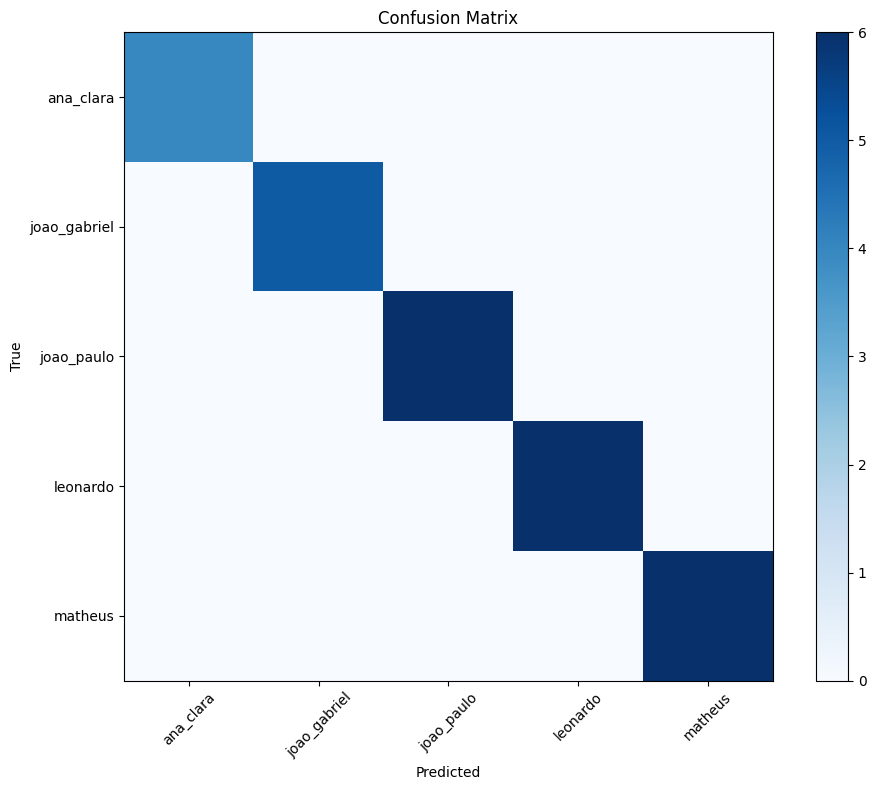

In [18]:
# Avaliar o modelo
evaluation = evaluate_model(model, test_loader, label_mapping, device=device)

# Exibir métricas de avaliação
print(f"Accuracy: {evaluation['accuracy']:.4f}")

# Exibir relatório de classificação
report = evaluation['classification_report']
for person in [label_mapping[i] for i in range(num_classes)]:
    print(f"{person}:")
    print(f"  Precision: {report[person]['precision']:.4f}")
    print(f"  Recall: {report[person]['recall']:.4f}")
    print(f"  F1-score: {report[person]['f1-score']:.4f}")

# Visualizar matriz de confusão
cm = evaluation['confusion_matrix']
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
class_names = [label_mapping[i] for i in range(num_classes)]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

### 9.5- Teste do Sistema

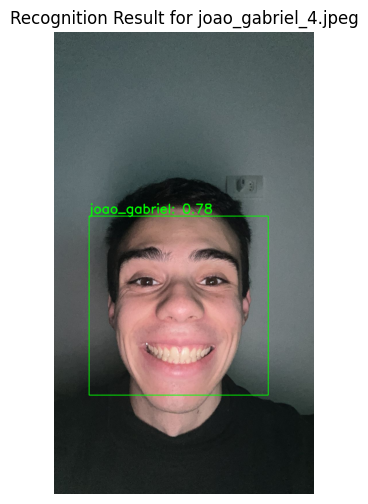

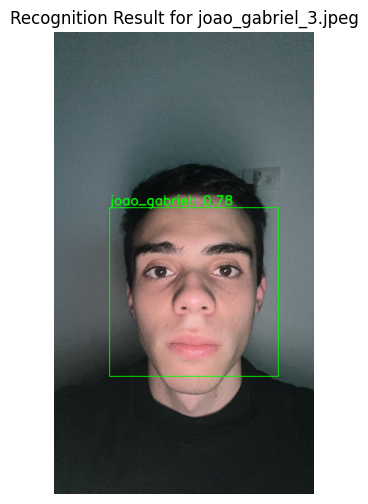

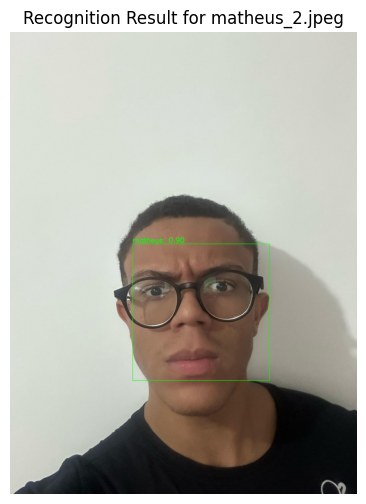

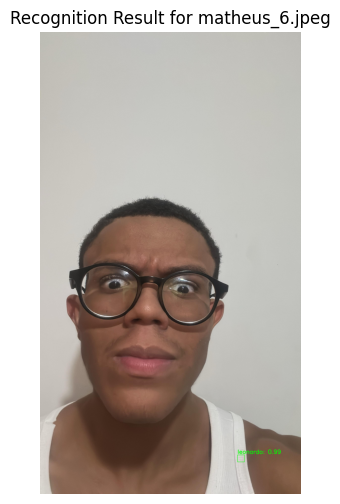

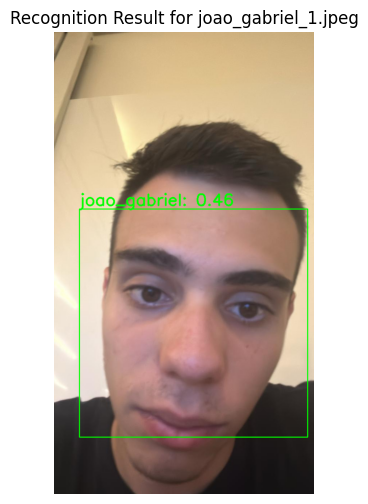

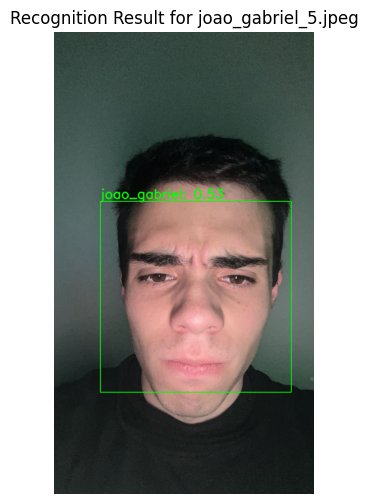

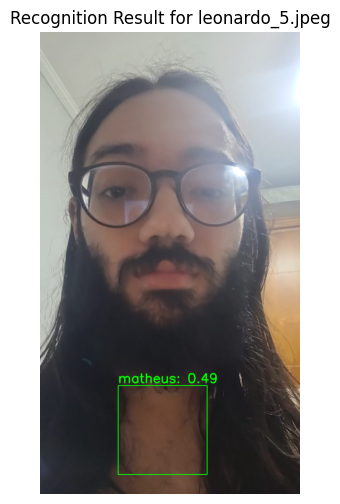

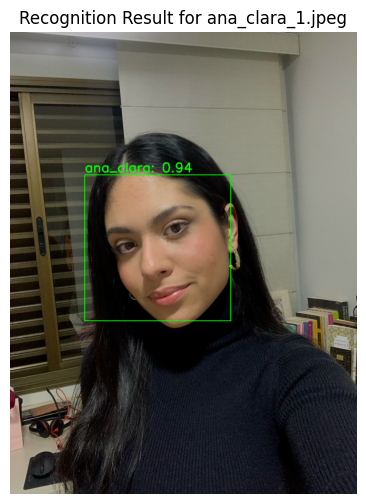

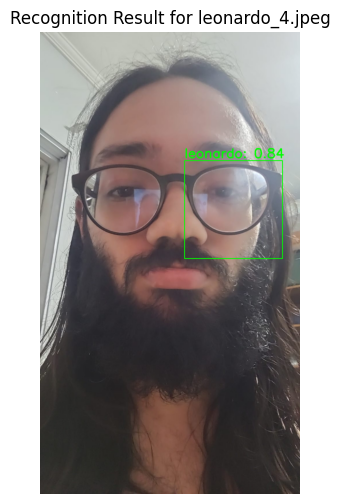

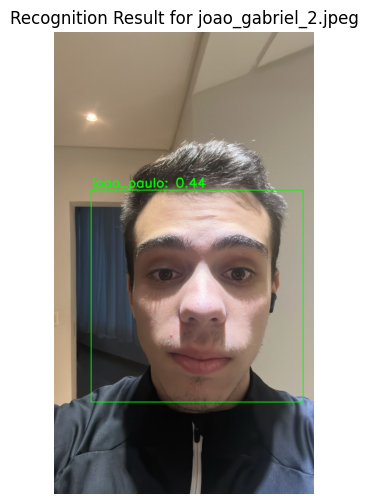

In [19]:
face_recognition_system = FaceRecognitionSystem(
    model_path=MODEL_SAVE_PATH,
    label_mapping=label_mapping,
    image_size=IMAGE_SIZE,
    device=device
)

test_image_dir = DATA_DIR
output_dir = '/content/MyDrive/MyDrive/faculdade_cdia_2023_2026/5-semestre/aprendizagem_maquina_5-semestre/projeto1_reconhecimentofacial_mlp/test_images'
os.makedirs(output_dir, exist_ok=True)

test_images = []
for root, _, files in os.walk(test_image_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            test_images.append(os.path.join(root, file))

num_samples = min(10, len(test_images))
test_images = random.sample(test_images, num_samples)

for i, image_path in enumerate(test_images):
    output_path = os.path.join(output_dir, f"result_{i}.jpg")
    result_image = face_recognition_system.visualize_recognition(image_path, output_path)

    if result_image is not None:
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Recognition Result for {os.path.basename(image_path)}")
        plt.show()

### 9.6- Teste por Webcam

In [20]:
webcam = WebcamFaceRecognition(face_recognition_system)
webcam.run_once()

<IPython.core.display.Javascript object>

MessageError: NotAllowedError: Permission denied